Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [ ]:
#import packages
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Data Reading/Data Understanding	

In [ ]:
# Defining the path for train and test images

data_dir_train = pathlib.Path('/content/drive/MyDrive/Skin/Train/')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin/Test/')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

# Dataset creation	
### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation
### Visualize the data
####code to visualize one instance of all the nine classes present in the dataset

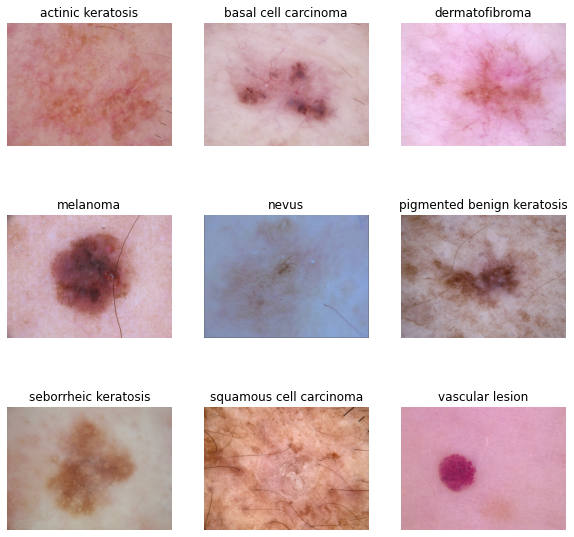

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
c=0
for i in class_names: 
  plt.subplot(3, 3, c + 1)
  image = plt.imread(str(list(data_dir_train.glob(i+'/*.jpg'))[1]))
  plt.title(i)
  plt.imshow(image)  
  plt.axis("off")
  c=c+1
  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building & training	
### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

# Model 1

In [ ]:
### code goes here

input_shape = (180,180,3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(3, 3),padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))
## Number of classes is 9


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### choose an appropirate optimiser and loss function
#using SparseCategoricalCrossentropy since CategoricalCrossentropy works with one-hot encoded targets
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_88 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 45, 45, 64)      

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,verbose=1
)

Epoch 1/20
56/56 [==============================] - 2s 28ms/step - loss: 1.9559 - accuracy: 0.2902 - val_loss: 1.8597 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6656 - accuracy: 0.4096 - val_loss: 1.6133 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5507 - accuracy: 0.4581 - val_loss: 1.5017 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4282 - accuracy: 0.4900 - val_loss: 1.5932 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3704 - accuracy: 0.5106 - val_loss: 1.3957 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3085 - accuracy: 0.5363 - val_loss: 1.4956 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2633 - accuracy: 0.5474 - val_loss: 1.4677 - val_accuracy: 0.5011
Epoch 8/20
56

### Visualizing training results

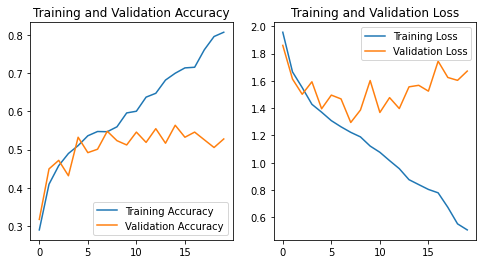

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

It is clearly overfitting since
- distinct gap between training and validation accuracy
- training accuracy is more than validation and vice versa for loss

# Data augmentation	

In [ ]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augment_layer = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(input_shape)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

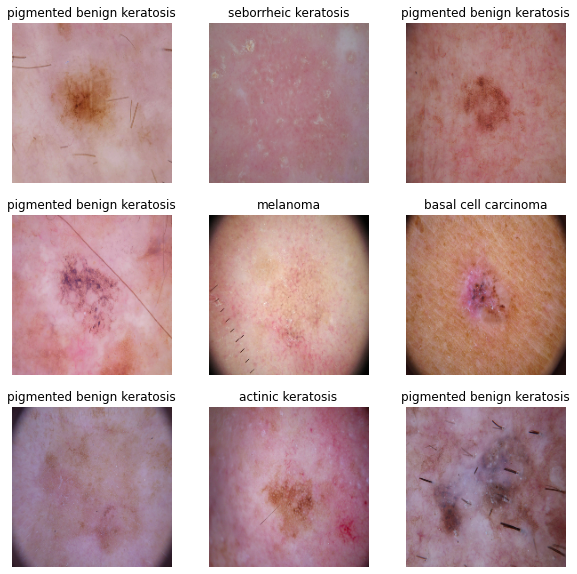

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augment_layer(img)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


# Model Building & training	

# Model 2


### Create the model, compile and train the model


In [ ]:
## use Dropout layer if there is an evidence of overfitting in your findings

input_shape = (180,180,3)

model = Sequential([data_augment_layer])
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(3, 3),padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))
## Number of classes is 9


### Compiling the model

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_24 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 90, 90, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 45, 45, 32)       0         
 ng2D)                                               

### Training the model

In [ ]:
## train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,verbose=1
)

Epoch 1/20
56/56 [==============================] - 3s 31ms/step - loss: 2.0557 - accuracy: 0.1886 - val_loss: 2.0233 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 2.0044 - accuracy: 0.2299 - val_loss: 2.0471 - val_accuracy: 0.2774
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.8707 - accuracy: 0.3097 - val_loss: 1.9862 - val_accuracy: 0.2215
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.7461 - accuracy: 0.3521 - val_loss: 1.6908 - val_accuracy: 0.4094
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.6180 - accuracy: 0.4141 - val_loss: 1.5520 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.6094 - accuracy: 0.4157 - val_loss: 1.5616 - val_accuracy: 0.4362
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5237 - accuracy: 0.4498 - val_loss: 1.4763 - val_accuracy: 0.5034
Epoch 8/20
56

### Visualizing the results

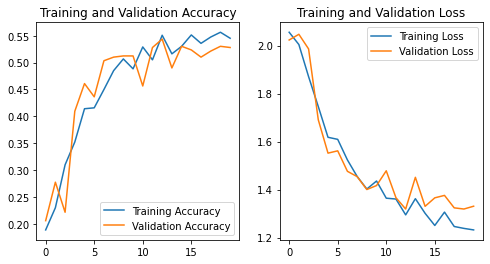

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- the overfitting issure is resolved now but the overall accuracy is reduced we will now look into it
- data augmentation along with dropout layers helped overcome the overfitting but the reduced accuracy can be due to class imbalance
- class rebalance can be done

# Class distribution	
#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

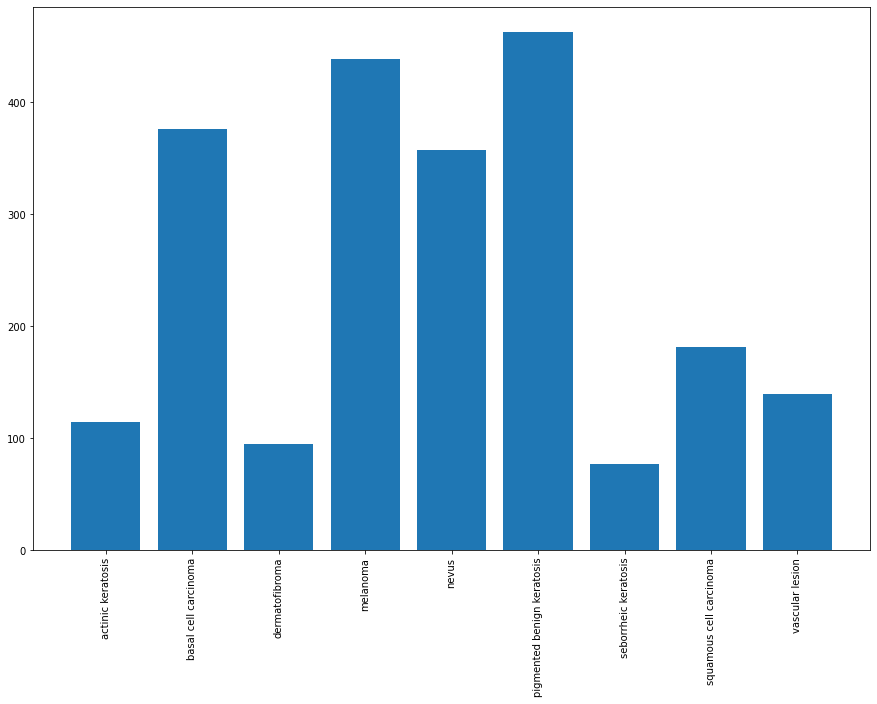

In [ ]:

dist=[]
for i in class_names:
    dist.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
plt.bar(class_names,dist)

#### Write your findings here: 
#### - Which class has the least number of samples?
- **Seborrheic Keratosis** - only 77 samples

#### - Which classes dominate the data in terms proportionate number of samples?
- **Pigmented benign Keratosis**, **nevus**,  **melanoma**, **basal cell carcinoma** - since they are having more than 350 images in each class and highest count is below 500, so proportionately these classes are dominating


# Handling class imbalances
####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset='/content/drive/MyDrive/Skin/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DB4430890>: 100%|██████████| 500/500 [00:17<00:00, 28.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DB4485F50>: 100%|██████████| 500/500 [00:17<00:00, 27.79 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E481B54D0>: 100%|██████████| 500/500 [00:17<00:00, 28.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5E4821ABD0>: 100%|██████████| 500/500 [01:15<00:00,  6.66 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5E48393410>: 100%|██████████| 500/500 [01:21<00:00,  6.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5EE17CE890>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5EE17F0650>: 100%|██████████| 500/500 [00:40<00:00, 12.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E48066F90>: 100%|██████████| 500/500 [00:17<00:00, 28.82 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5EE17D64D0>: 100%|██████████| 500/500 [00:18<00:00, 27.28 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:

path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,/content/drive/MyDrive/Skin/Train/actinic kera...,actinic keratosis
1,/content/drive/MyDrive/Skin/Train/actinic kera...,actinic keratosis
2,/content/drive/MyDrive/Skin/Train/actinic kera...,actinic keratosis
3,/content/drive/MyDrive/Skin/Train/actinic kera...,actinic keratosis
4,/content/drive/MyDrive/Skin/Train/actinic kera...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin/Train/vascular les...,vascular lesion
2235,/content/drive/MyDrive/Skin/Train/vascular les...,vascular lesion
2236,/content/drive/MyDrive/Skin/Train/vascular les...,vascular lesion
2237,/content/drive/MyDrive/Skin/Train/vascular les...,vascular lesion


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Skin/Train/vascular lesion/output/vascular lesion_original_ISIC_0034196.jpg_81095782-56cd-4332-8d7a-e8543d0a6618.jpg',
 '/content/drive/MyDrive/Skin/Train/vascular lesion/output/vascular lesion_original_ISIC_0026456.jpg_8d5da3df-dbce-434c-8577-3a3bce5dab18.jpg',
 '/content/drive/MyDrive/Skin/Train/vascular lesion/output/vascular lesion_original_ISIC_0025606.jpg_5b65721a-d38f-40de-a2cb-e077844ede6c.jpg',
 '/content/drive/MyDrive/Skin/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_bbd95d94-1af5-4fc9-951c-c3ba175d68cd.jpg',
 '/content/drive/MyDrive/Skin/Train/vascular lesion/output/vascular lesion_original_ISIC_0025628.jpg_a0a63716-6c47-4814-972a-79cc80c33db2.jpg',
 '/content/drive/MyDrive/Skin/Train/vascular lesion/output/vascular lesion_original_ISIC_0027256.jpg_05c88061-c4d3-429f-8bf8-159047bfb91a.jpg',
 '/content/drive/MyDrive/Skin/Train/vascular lesion/output/vascular lesion_original_ISIC_0032890.jpg_0a3d223f-9a2c-4200-918a-34ffea5f56c

In [ ]:
len(path_list_new)

4500

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
#merge original samples with augmented samples
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
#new sample sizes for each class after augmentation
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [ ]:
len(new_df['Path'])

6739

In [ ]:
data_dir_train

PosixPath('/content/drive/MyDrive/Skin/Train')

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

# Dataset creation	

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
data_dir_train='/content/drive/MyDrive/Skin/Train/' #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building & training	

# Model 3

#### Create model (make sure to include normalization)

In [ ]:


input_shape = (180,180,3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(3, 3),padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(Dense(9))

model.add(Activation('softmax'))
## Number of classes is 9


#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_48 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_49 (Bat  (None, 90, 90, 32)     

#### **Todo:**  Train your model

In [ ]:
## train your model for 30 epochs
##to minimize the fluctuations observed in the validation accuracy it is suggested to reduce learning
#rate to make sure the model learns those details properly
epochs = 30
learning_rate=ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,verbose=1,
  callbacks=[learning_rate]
)

Epoch 1/30
169/169 [==============================] - 116s 225ms/step - loss: 1.6074 - accuracy: 0.4479 - val_loss: 7.1759 - val_accuracy: 0.1084 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 39s 224ms/step - loss: 1.0717 - accuracy: 0.6111 - val_loss: 2.8249 - val_accuracy: 0.3267 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 39s 222ms/step - loss: 0.8014 - accuracy: 0.7099 - val_loss: 1.4391 - val_accuracy: 0.5546 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 39s 223ms/step - loss: 0.5955 - accuracy: 0.7799 - val_loss: 0.7941 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 39s 222ms/step - loss: 0.4827 - accuracy: 0.8197 - val_loss: 1.1111 - val_accuracy: 0.6362 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 39s 222ms/step - loss: 0.3618 - accuracy: 0.8655 - val_loss: 2.6506 - val_accuracy: 0.3994 - lr: 0.0010
Epoch 7/30
169/169 [==============================]

####  Visualize the model results

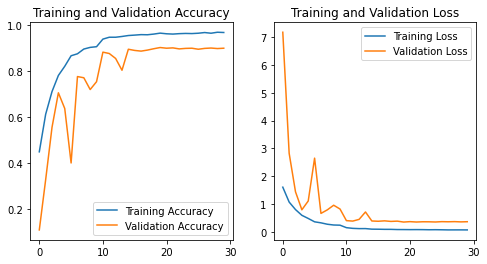

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- the overfitting issue is clearly reduced now than what we saw in Model 1 along with gain in accuracy than Model 2
- the class rebalance has helped in both getting good accuracy as well as reducing overfitting. However more improvements can be brought by introducing more layers or increasing epochs (resource constraints).